<a href="https://colab.research.google.com/github/guangyitan/ImageProcessing-FaceMaskClassification/blob/main/Train_ResNet152V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm

from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
project_path = '/content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/'
model_path = '/content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/Trained_Models/ResNet152V2/'
# training_zip_path = project_path + 'face-mask-detector.zip'
dataset_path = project_path + 'Balanced_Dataset'

print(dataset_path)

/content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/Balanced_Dataset


In [ ]:
# Initialize the path for dataset
imagePaths=list(paths.list_images(dataset_path))
print("Number of dataset:", len(imagePaths))

Number of dataset: 2500


In [ ]:
imagePaths[0].split(os.path.sep)[-2]


'Mask_Nose_Mouth'

# Load and preprocess dataset

## Load from images

In [ ]:
# # initialize dataset and its label
# data=[]
# labels=[]

# for i in tqdm(imagePaths):

#   # get the dataset label from its path
#   label = i.split(os.path.sep)[-2]
#   labels.append(label)

#   # get the dataset image, convert to array and preprocess it
#   image = load_img(i, target_size=(224,224))
#   image = img_to_array(image)
#   image = preprocess_input(image)
#   data.append(image)

## Load from array

In [ ]:
# data = []
# labels = []

# load model history
import pickle

with open('/content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/Loaded_Dataset/images_array.txt', 'rb') as filehandle:
    # read the data as binary data stream
    data = pickle.load(filehandle)

with open('/content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/Loaded_Dataset/labels.txt', 'rb') as filehandle2:
    # read the data as binary data stream
    labels = pickle.load(filehandle2)

In [ ]:
# check if data and labels are loaded correctly
print(len(data))
print(data[0])

print(len(labels))
print(labels[0])

2500
[[[-0.9764706   0.04313731  0.1686275 ]
  [-1.         -0.00392157  0.12941182]
  [-1.          0.01176476  0.13725495]
  ...
  [-0.99215686 -0.06666666  0.21568632]
  [-1.         -0.09803921  0.19215691]
  [-1.         -0.09019607  0.18431377]]

 [[-0.99215686  0.02745104  0.15294123]
  [-1.         -0.00392157  0.12941182]
  [-1.          0.01176476  0.12156868]
  ...
  [-1.         -0.11372548  0.17647064]
  [-1.         -0.11372548  0.17647064]
  [-1.         -0.10588235  0.17647064]]

 [[-1.          0.0196079   0.14509809]
  [-0.9843137   0.01176476  0.12941182]
  [-1.         -0.00392157  0.09803927]
  ...
  [-1.         -0.12156862  0.1686275 ]
  [-1.         -0.10588235  0.18431377]
  [-0.99215686 -0.11372548  0.18431377]]

 ...

 [[-0.8352941   0.19215691  0.33333337]
  [-0.8117647   0.21568632  0.35686278]
  [-0.84313726  0.20000005  0.33333337]
  ...
  [-0.00392157  0.21568632  0.22352946]
  [ 0.02745104  0.22352946  0.254902  ]
  [ 0.02745104  0.22352946  0.27843142]

In [ ]:
# convert data and label to np array
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# labels = to_categorical(labels)

# split the data into 70% for training and 30% for testing 
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.30, stratify=labels, random_state=10)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# check the shape of splited dataset
print("trainX:", trainX.shape)
print("testX:", testX.shape)
print("trainY:", trainY.shape)
print("testY:", testY.shape)

trainX: (1750, 224, 224, 3)
testX: (750, 224, 224, 3)
trainY: (1750, 5)
testY: (750, 5)


# Start Constructing the Model 

In [ ]:
# load the ResNet15V2 network, ensuring the head FC layer sets are left off
baseModel = ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the base model(MobileNetV2)
# I'm using softmax for multiclass classification 
# the output of model has 3 classes (mask, no_mask, wrong_mask)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(5, activation="softmax")(headModel)

# place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and set them as not trainable
for layer in baseModel.layers:
	layer.trainable = False

# check the architecture of the model
# Total params: 2,422,339
# Trainable params: 164,355 (from the layers that was added to the MobileNetV2)
# Non-trainable params: 2,257,984
model.summary()

234561536/234545216 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

# Training the Model

In [ ]:
# initialize the learning rate, epochs and batch size to train the model
learning_rate = 0.001
epochs = 20
bs = 32

# initialize the optimizer 
optimizer = Adam(learning_rate = learning_rate, decay=learning_rate/epochs)

# complie the model
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

# start training the model
hist = model.fit(
    aug.flow(trainX, trainY, batch_size = bs),
    steps_per_epoch = len(trainX)//bs,
    validation_data = (testX, testY),
    validation_steps = len(testX)//bs,
    epochs = epochs
)

Epoch 1/20
54/54 [==============================] - 67s 876ms/step - loss: 0.8569 - accuracy: 0.6758 - val_loss: 0.4085 - val_accuracy: 0.8600
Epoch 2/20
54/54 [==============================] - 41s 760ms/step - loss: 0.4455 - accuracy: 0.8382 - val_loss: 0.2857 - val_accuracy: 0.8813
Epoch 3/20
54/54 [==============================] - 41s 761ms/step - loss: 0.3509 - accuracy: 0.8714 - val_loss: 0.2520 - val_accuracy: 0.9027
Epoch 4/20
54/54 [==============================] - 42s 773ms/step - loss: 0.3001 - accuracy: 0.8871 - val_loss: 0.2316 - val_accuracy: 0.9080
Epoch 5/20
54/54 [==============================] - 42s 774ms/step - loss: 0.3005 - accuracy: 0.8929 - val_loss: 0.2083 - val_accuracy: 0.9213
Epoch 6/20
54/54 [==============================] - 41s 754ms/step - loss: 0.2592 - accuracy: 0.9057 - val_loss: 0.2453 - val_accuracy: 0.8987
Epoch 7/20
54/54 [==============================] - 41s 755ms/step - loss: 0.2566 - accuracy: 0.9075 - val_loss: 0.1688 - val_accuracy: 0.9427

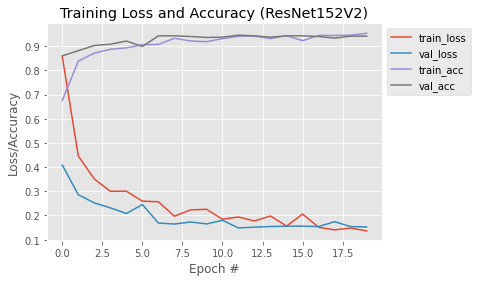

In [ ]:
# plot the training loss and accuracy graph
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (ResNet152V2)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
# Test the model using testing dataset
predict = model.predict(testX, batch_size = bs)

predict = np.argmax(predict,axis=1)
print(classification_report(testY.argmax(axis=1), predict, target_names=lb.classes_))

                           precision    recall  f1-score   support

              Corret_Mask       0.96      0.91      0.93       150
      Incorrect_Mask_Chin       0.89      0.98      0.93       150
Incorrect_Mask_Mouth_Chin       0.96      0.89      0.92       150
Incorrect_Mask_Nose_Mouth       0.91      0.99      0.95       150
                  No_Mask       1.00      0.95      0.97       150

                 accuracy                           0.94       750
                macro avg       0.94      0.94      0.94       750
             weighted avg       0.94      0.94      0.94       750



# Save model, weights, training history

In [ ]:
save_model_path = model_path + "Saved_Model"
save_weights_path = model_path +"Saved_Weights"

#Save the trained model
model.save(save_model_path) 

# Save the weights
model.save_weights(save_weights_path)

INFO:tensorflow:Assets written to: /content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/Trained_Models/ResNet152V2/Saved_Model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
import pickle 
with open(model_path + 'hist.txt', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(hist, filehandle)

INFO:tensorflow:Assets written to: ram://8176680a-818e-4675-a2a9-9c9598dd8a8e/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Load Model and History

In [ ]:
# # To load the model
new_model = load_model('/content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/Trained_Models/ResNet152V2/Saved_model')

In [ ]:
# load model history
import pickle

with open('/content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/Trained_Models/ResNet152V2/hist.txt', 'rb') as filehandle:
    # read the data as binary data stream
    hist = pickle.load(filehandle)

In [ ]:
# function ClickConnect(){
#     console.log("Clicked on connect button"); 
#     document.querySelector("colab-connect-button").click()
# }
# setInterval(ClickConnect,60000)